<a href="https://colab.research.google.com/github/Imronrsya/CERN-Electron-Collision-Data/blob/main/CERN_Electron_Collision_Data_Tubes_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

#Import Library

In [1]:
# Install Library
!pip install -q kagglehub xgboost

# Basic Tools
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# KaggleHub (download dataset)
import kagglehub

# Preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Dataset

In [2]:
# Download Dataset
path = kagglehub.dataset_download("fedesoriano/cern-electron-collision-data")
csv_path = f"{path}/dielectron.csv"

# Load Data Asli
df = pd.read_csv(csv_path)

print(f"Dimensi Data Asli (Raw): {df.shape}")
df.head()

100%|██████████| 6.25M/6.25M [00:01<00:00, 6.39MB/s]

Extracting files...


Dimensi Data Asli (Raw): (100000, 19)


,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


#EDA

##4.1 Informasi Dasar

In [3]:
# Informasi Dasar
print("=== INFO DATASET (RAW) ===")
df.info()

# Cek Duplikat & Null
print("\n=== CEK DUPLIKAT & NULL ===")
print(f"Jumlah Baris Duplikat : {df.duplicated().sum()}")
print(f"Jumlah Missing Values : {df.isnull().sum().sum()}")

# Informasi Statistik
print("\n=== STATISTIK DESKRIPTIF ===")
display(df.describe().round(2))

=== INFO DATASET (RAW) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64  
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64  
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB

=== CEK DUPL

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
count,100000.00,1.000000e+05,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.0,99915.00
mean,147935.33,4.957212e+08,36.44,0.14,0.18,-1.51,14.41,-0.06,0.02,-0.01,44.00,-0.00,0.12,-1.59,13.80,-0.07,0.02,-0.0,30.02
std,920.31,4.037703e+08,41.22,13.40,13.47,51.60,12.39,1.46,1.80,1.00,46.75,13.13,13.17,61.43,12.46,1.74,1.82,1.0,25.26
min,146511.00,6.414000e+03,0.38,-250.59,-126.08,-840.99,0.22,-4.17,-3.14,-1.00,0.47,-233.73,-145.65,-655.40,0.03,-7.06,-3.14,-1.0,2.00
25%,147114.00,2.023970e+08,8.46,-5.23,-5.28,-15.86,3.77,-1.28,-1.53,-1.00,11.06,-4.79,-4.61,-22.04,3.74,-1.89,-1.56,-1.0,12.45
50%,147929.00,3.902759e+08,21.72,0.14,0.10,-0.31,12.97,-0.06,0.03,-1.00,25.26,-0.04,0.08,-0.69,11.69,-0.14,0.03,-1.0,21.28
75%,149011.00,6.338891e+08,50.00,5.71,5.65,13.21,20.02,1.14,1.56,1.00,66.93,4.82,5.06,19.01,19.60,1.77,1.60,1.0,39.03
max,149182.00,1.791247e+09,850.60,134.54,147.47,760.10,265.58,2.62,3.14,1.00,948.38,227.33,166.28,935.56,281.65,3.06,3.14,1.0,110.00


##4.2 Analisis Distribusi Target (Invariant Mass)

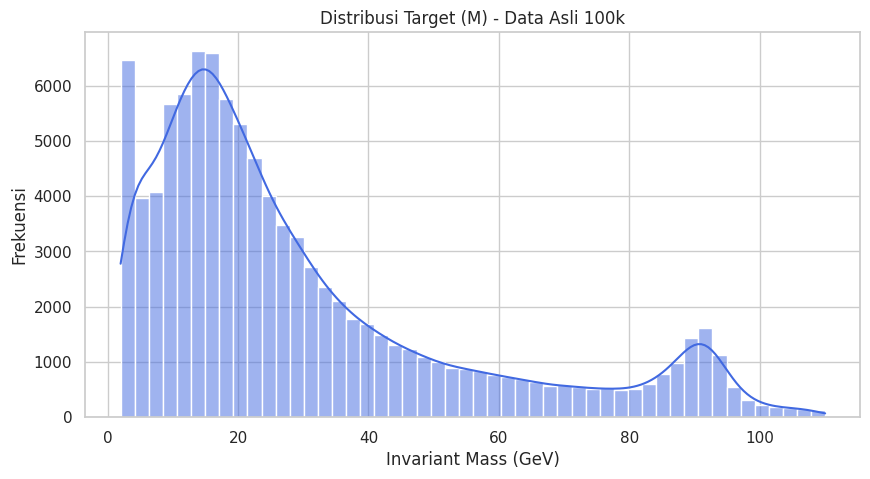

Skewness: 1.3010


In [4]:
# Distribusi Target
plt.figure(figsize=(10, 5))
sns.histplot(df['M'], kde=True, bins=50, color='royalblue')
plt.title("Distribusi Target (M) - Data Asli 100k")
plt.xlabel("Invariant Mass (GeV)")
plt.ylabel("Frekuensi")
plt.show()

print(f"Skewness: {df['M'].skew():.4f}")

## 4.3 Analisis Korelasi

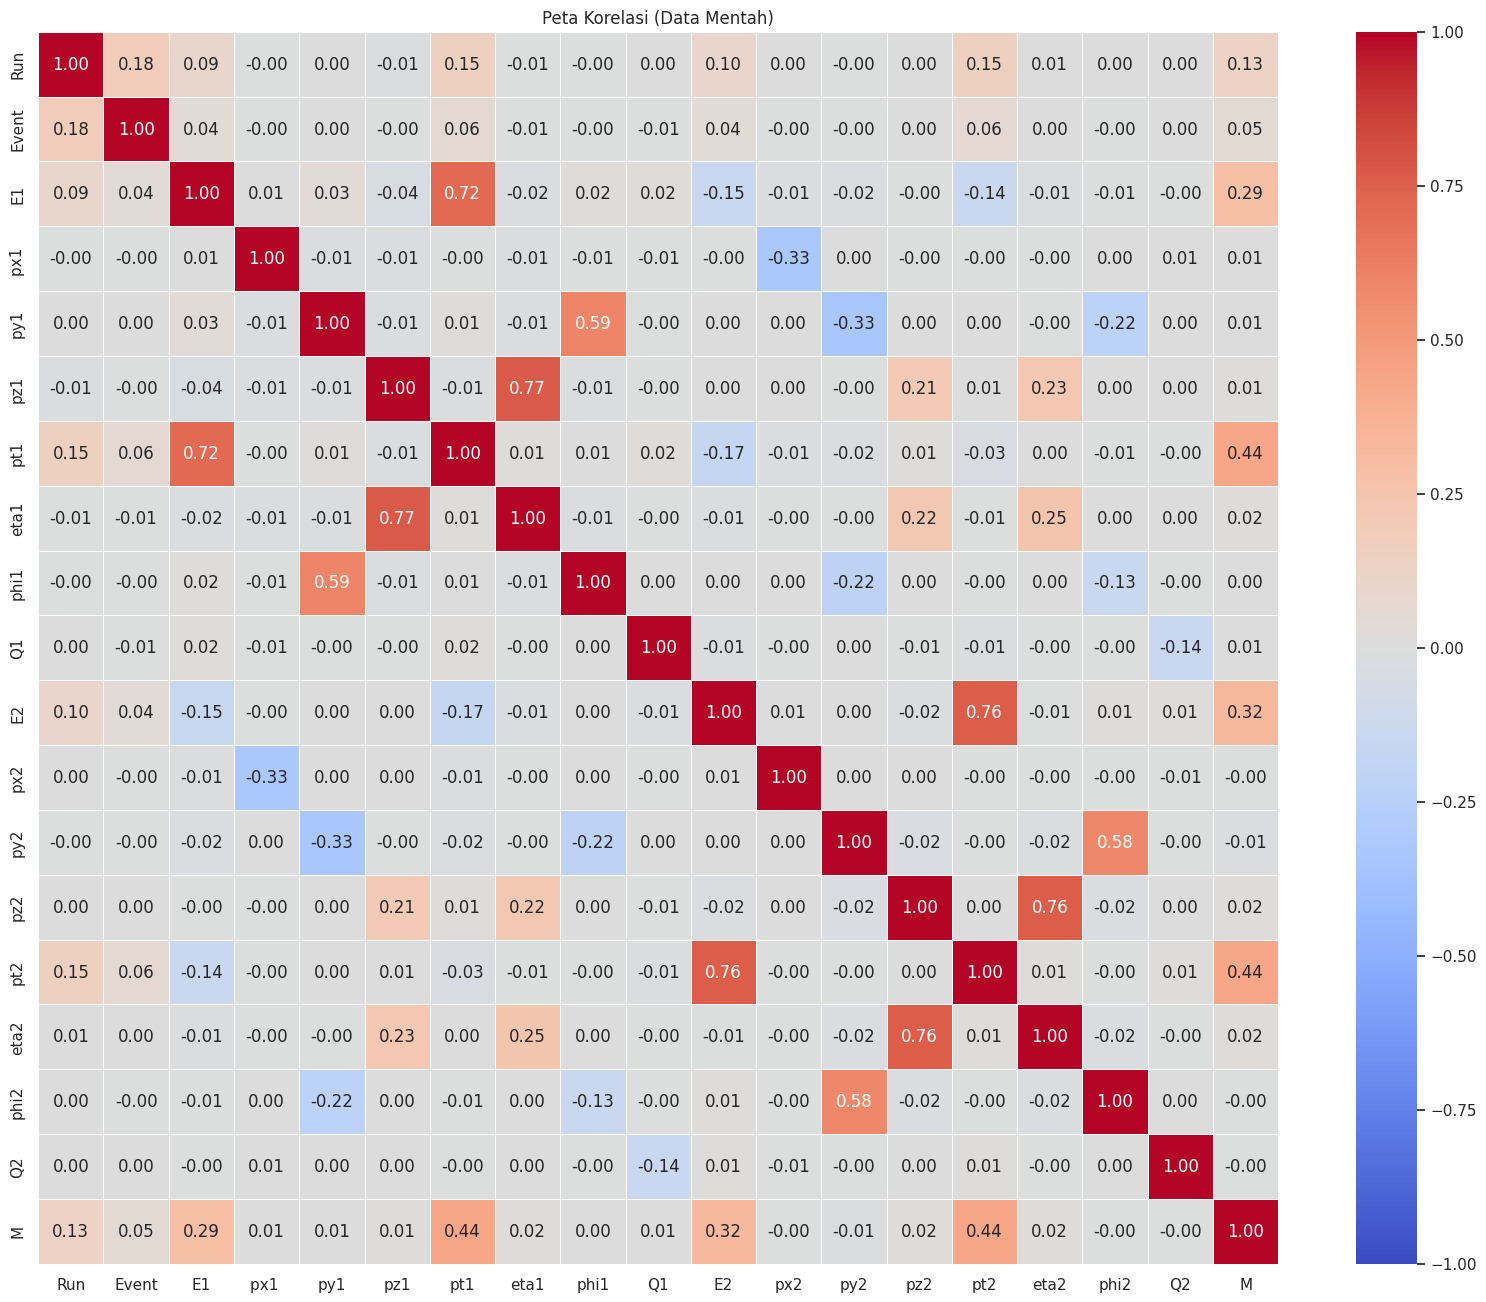

=== KORELASI TERHADAP TARGET 'M' ===
M        1.000000
pt2      0.437158
pt1      0.437140
E2       0.324660
E1       0.285231
Run      0.129452
Event    0.052364
eta2     0.018772
eta1     0.017102
pz2      0.015702
pz1      0.011526
py1      0.007538
px1      0.006112
Q1       0.005624
phi1     0.001833
Q2      -0.000444
phi2    -0.004145
px2     -0.004419
py2     -0.011725
Name: M, dtype: float64


In [5]:
# Hitung korelasi
correlation = df.corr()

# Visualisasi Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Peta Korelasi (Data Mentah)")
plt.show()

# Tampilkan Ranking Korelasi terhadap M
print("=== KORELASI TERHADAP TARGET 'M' ===")
print(correlation['M'].sort_values(ascending=False))

## 4.4 Analisis Outlier (Boxplot)

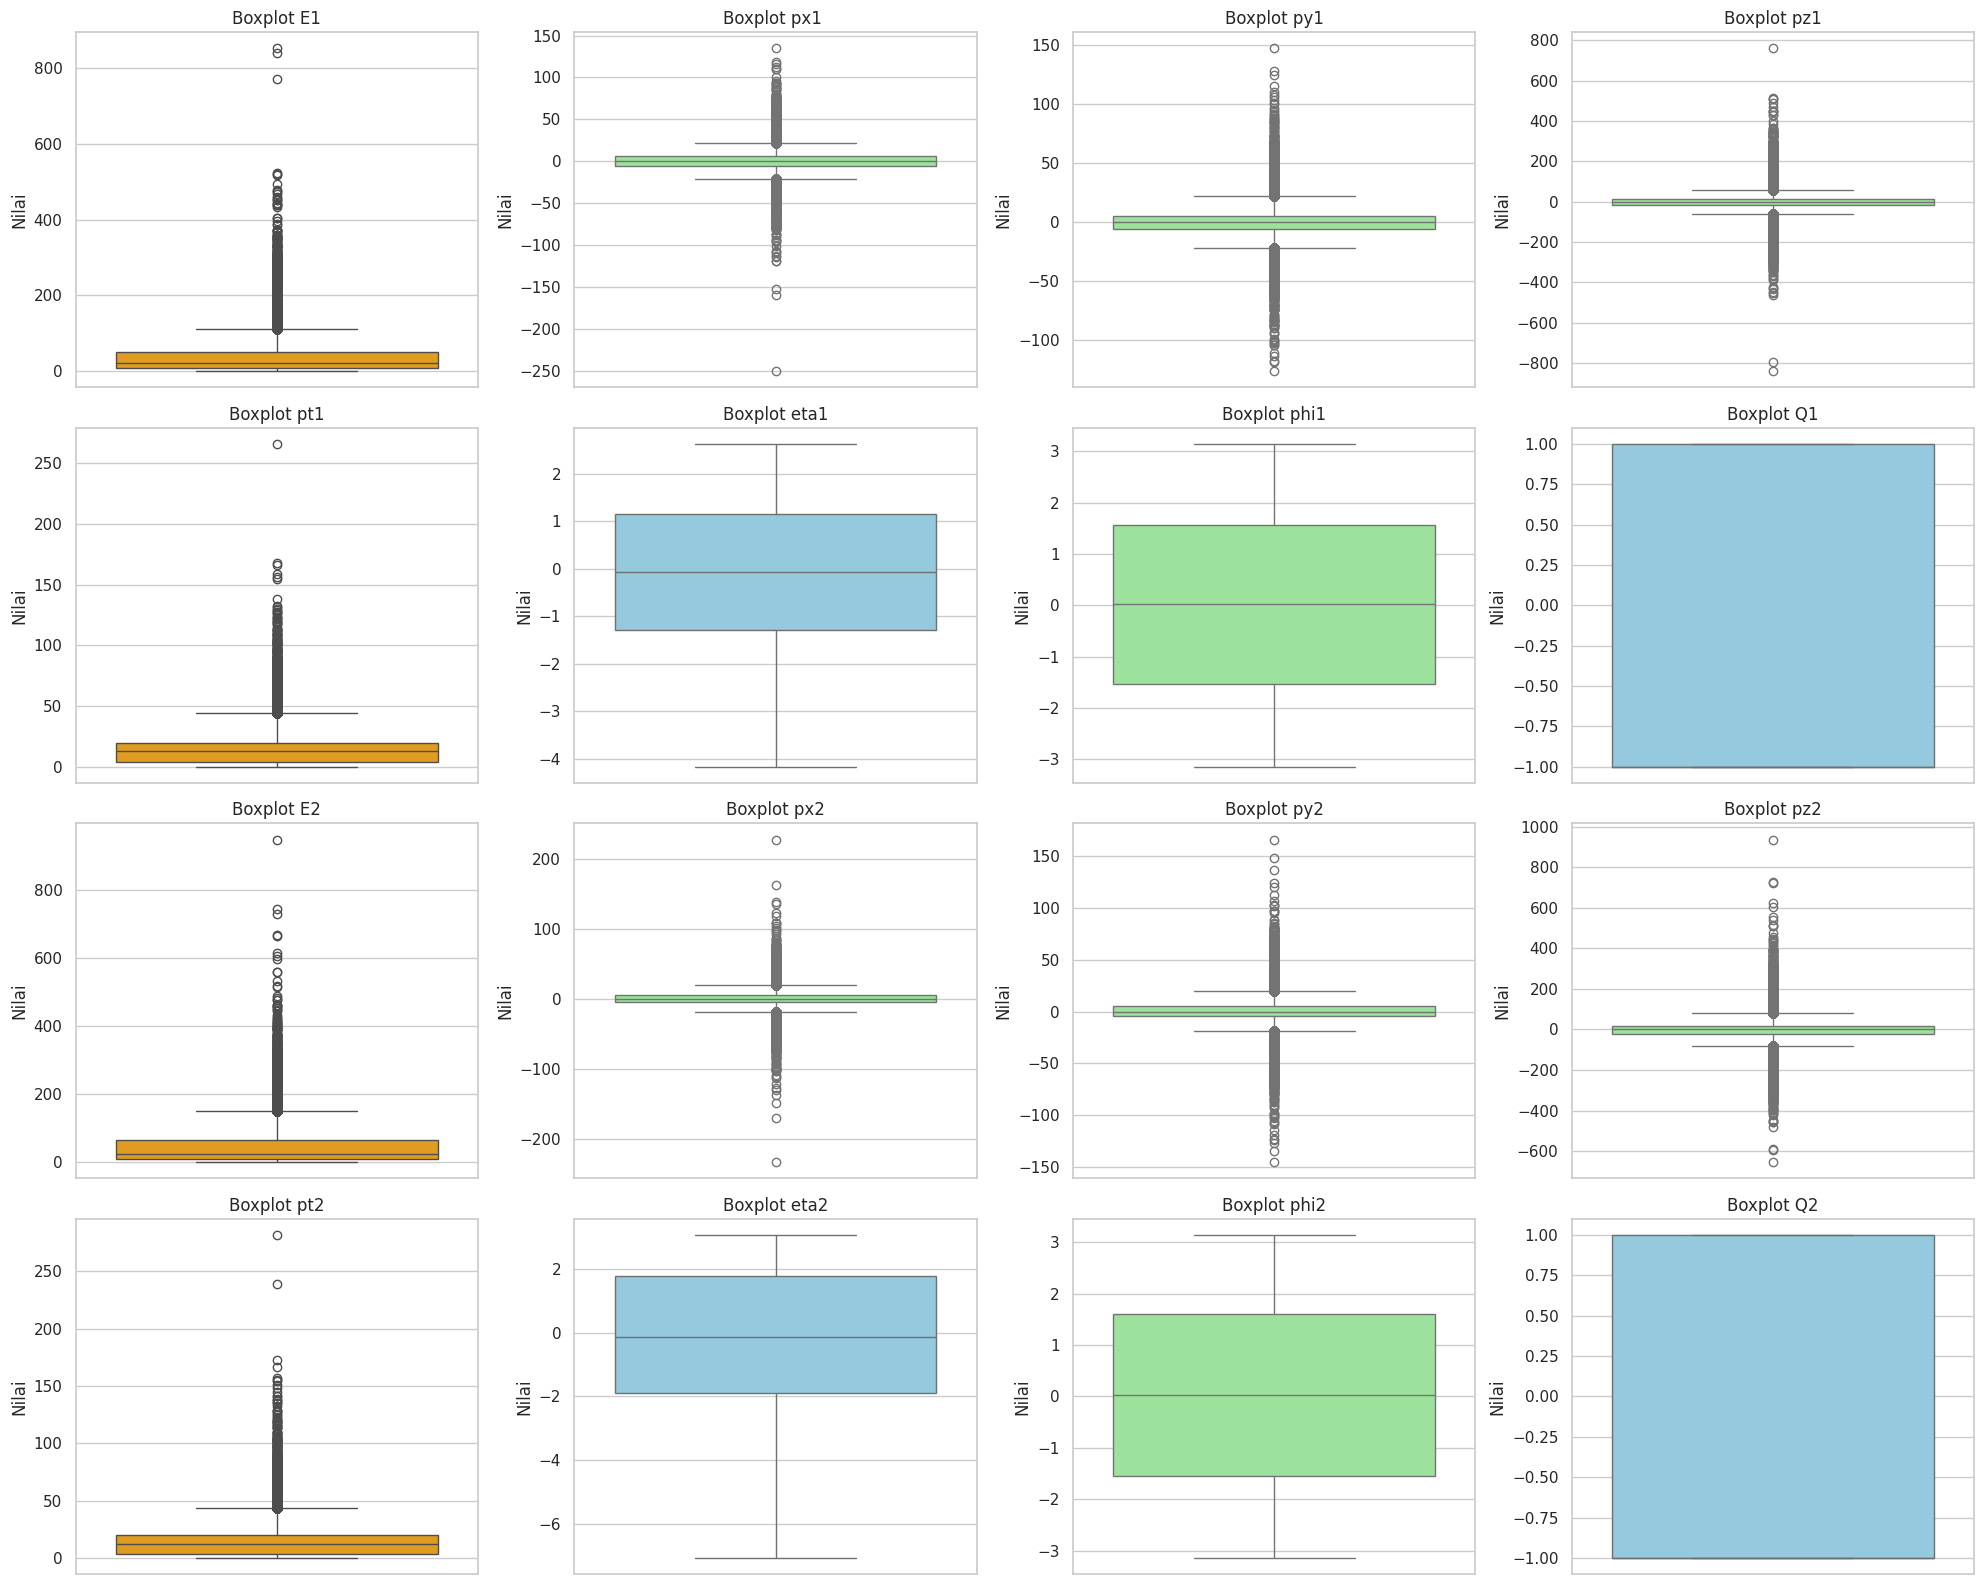

Total Fitur Dicek: 16


In [6]:
# Ambil semua kolom kecuali Target 'M' dan ID 'Run', 'Event'
features_to_check = [col for col in df.columns if col not in ['M', 'Run', 'Event']]

n_cols = 4
n_rows = 4

plt.figure(figsize=(20, 16))

for i, col in enumerate(features_to_check):
    if i >= n_cols * n_rows: break
    plt.subplot(n_rows, n_cols, i+1)
    color = 'skyblue'
    if 'E' in col or 'pt' in col: color = 'orange'
    elif 'p' in col and 't' not in col: color = 'lightgreen'

    sns.boxplot(y=df[col], color=color)
    plt.title(f"Boxplot {col}")
    plt.ylabel("Nilai")

plt.tight_layout()
plt.show()

print(f"Total Fitur Dicek: {len(features_to_check)}")

## 4.5 Pola Hubungan Fitur vs Target (Scatter Plot)

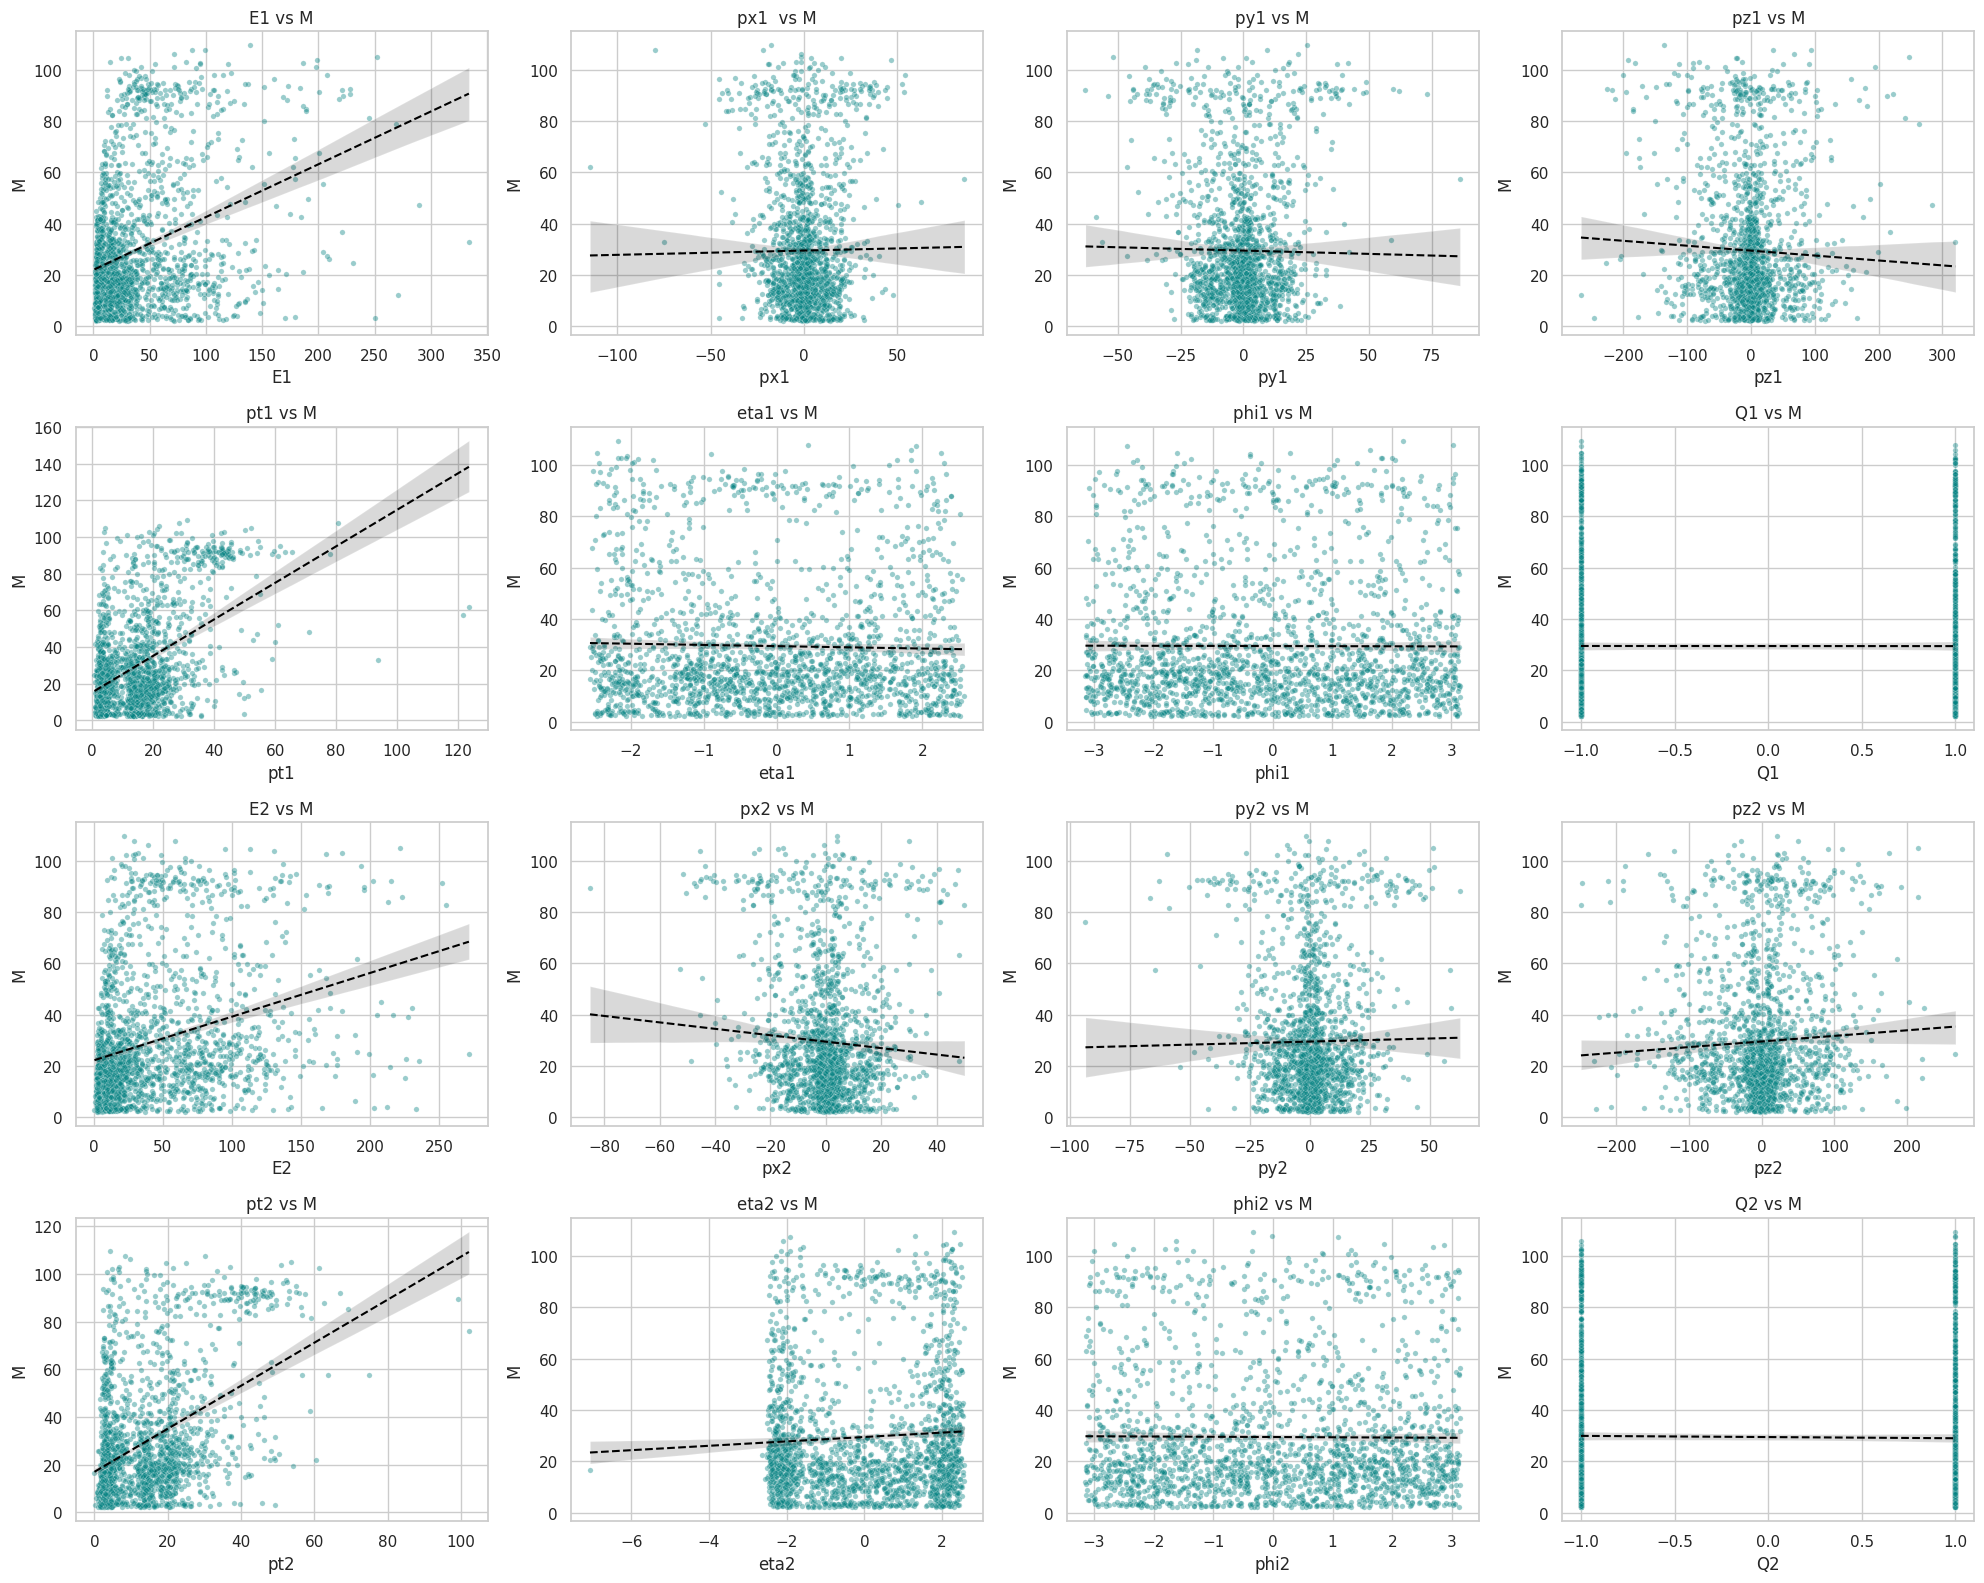

Scatter Plot ditampilkan untuk 16 fitur dengan 2.000 sampel data.


In [7]:
# Ambil semua kolom kecuali Target 'M' dan ID 'Run', 'Event'
features_to_check = [col for col in df.columns if col not in ['M', 'Run', 'Event']]

# Menggunakan 2.000 sampel
df_plot = df.sample(n=2000, random_state=42)

n_cols = 4
n_rows = 4

plt.figure(figsize=(20, 16))

for i, col in enumerate(features_to_check):
    if i >= n_cols * n_rows: break

    plt.subplot(n_rows, n_cols, i+1)

    sns.scatterplot(x=df_plot[col], y=df_plot['M'], alpha=0.4, s=15, color='teal')

    sns.regplot(x=df_plot[col], y=df_plot['M'], scatter=False, color='black', line_kws={'linestyle':'--', 'linewidth':1.5})

    plt.title(f"{col} vs M")
    plt.ylabel("M")

plt.tight_layout()
plt.show()

print(f"Scatter Plot ditampilkan untuk {len(features_to_check)} fitur dengan 2.000 sampel data.")

#Preprocessing

## 5.1 Data Cleaning & Sampling

In [8]:
print(f"Jumlah Data Awal (Raw): {df.shape[0]}")

cols_to_drop = ['Run', 'Event']
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

df_clean = df_clean.drop_duplicates()
df_clean = df_clean.dropna()

print(f"Jumlah Data Bersih (Full): {df_clean.shape[0]}")

# Sampling 2.000 data untuk model
df_final = df_clean.sample(n=2000, random_state=42)

print(f"Data Final Model: {df_final.shape}")

Jumlah Data Awal (Raw): 100000
Jumlah Data Bersih (Full): 99892
Data Final Model: (2000, 17)


## 5.2 Feature Extraction

In [9]:
X = df_final.drop('M', axis=1)
y = df_final['M']

print(f"Fitur (X): {X.shape}")
print(f"Target (y): {y.shape}")

Fitur (X): (2000, 16)
Target (y): (2000,)


## 5.3 Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Latih : {X_train.shape[0]}")
print(f"Data Uji   : {X_test.shape[0]}")

Data Latih : 1600
Data Uji   : 400


## 5.4 Feature Scaling

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Scaling Selesai.")
display(X_train_scaled.head(3))

Scaling Selesai.


,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2
0,0.635323,4.702741,-1.273596,-0.120202,3.923809,-0.038008,-0.195884,0.998751,-0.345960,-0.999083,-0.096769,0.428226,-0.012654,0.799518,-1.634904,-0.981423
1,-0.268046,-0.846909,-0.427967,0.436864,-0.192021,0.978034,-1.527122,-1.001251,-0.914102,0.008811,-0.184153,0.026009,-0.903574,0.155395,-0.910671,1.018929
2,-0.315717,-1.035860,0.872469,-0.200917,0.295651,-0.407229,1.281921,0.998751,-0.650733,0.381825,0.128146,-0.213261,-0.728515,-1.002618,0.183414,-0.981423


#Modelling

## 6.1 Inisialisasi Model

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=100, gamma='scale'),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
}

print("Model berhasil diinisialisasi.")

Model berhasil diinisialisasi.


## 6.2 Validasi (5-Fold Cross-Validation)

In [13]:
results_cv = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Memulai Cross-Validation...")

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    rmse_scores = -cv_scores

    results_cv.append({
        "Model": name,
        "CV RMSE Mean": rmse_scores.mean(),
        "CV RMSE Std": rmse_scores.std()
    })

df_cv = pd.DataFrame(results_cv).sort_values(by="CV RMSE Mean")
print("\n=== HASIL VALIDASI (DATA LATIH) ===")
display(df_cv)

Memulai Cross-Validation...

=== HASIL VALIDASI (DATA LATIH) ===


,Model,CV RMSE Mean,CV RMSE Std
1,SVR (RBF Kernel),6.371918,0.673354
3,XGBoost,10.115159,0.603360
2,Random Forest,13.112468,0.502475
0,Linear Regression,20.076783,0.639040


## 6.3 Training Model Final

In [14]:
trained_models = {}
print("Melatih model final...")

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"Model {name} selesai dilatih.")

Melatih model final...
Model Linear Regression selesai dilatih.
Model SVR (RBF Kernel) selesai dilatih.
Model Random Forest selesai dilatih.
Model XGBoost selesai dilatih.


#Evaluasi

## 7.1 Hitung Metrik Evaluasi

In [15]:
final_results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    final_results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    })

df_final = pd.DataFrame(final_results).sort_values(by="RMSE")
print("\n=== PERFORMA AKHIR (DATA UJI) ===")
display(df_final)


=== PERFORMA AKHIR (DATA UJI) ===


,Model,MAE,RMSE,R2 Score
1,SVR (RBF Kernel),3.110486,5.700888,0.947443
3,XGBoost,6.562970,9.673220,0.848683
2,Random Forest,9.305544,13.173332,0.719368
0,Linear Regression,14.199885,19.489939,0.385719


## 7.2 Visualisasi Perbandingan Model

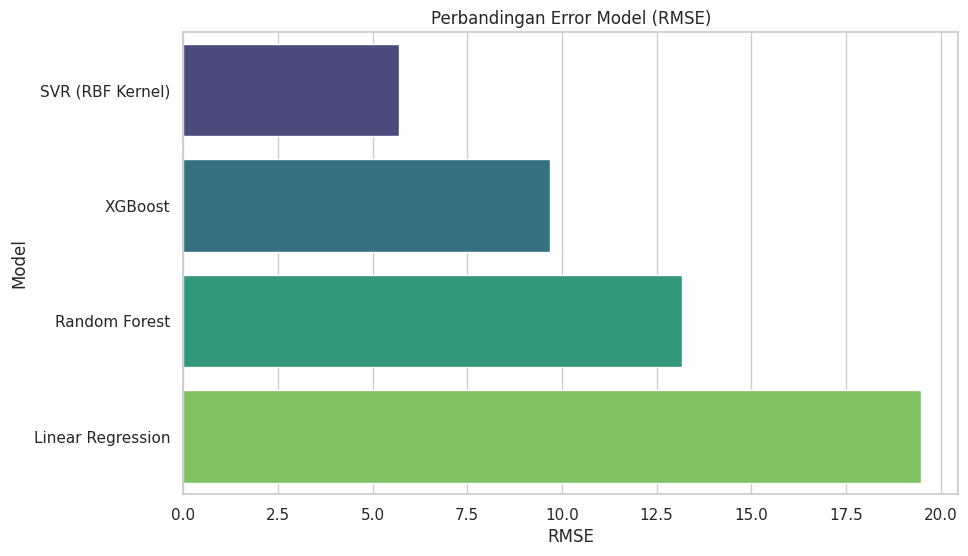

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x="RMSE", y="Model", data=df_final, palette="viridis")
plt.title("Perbandingan Error Model (RMSE)")
plt.xlabel("RMSE")
plt.show()

## 7.3 Analisis Model Terbaik

Model Terbaik: SVR (RBF Kernel)


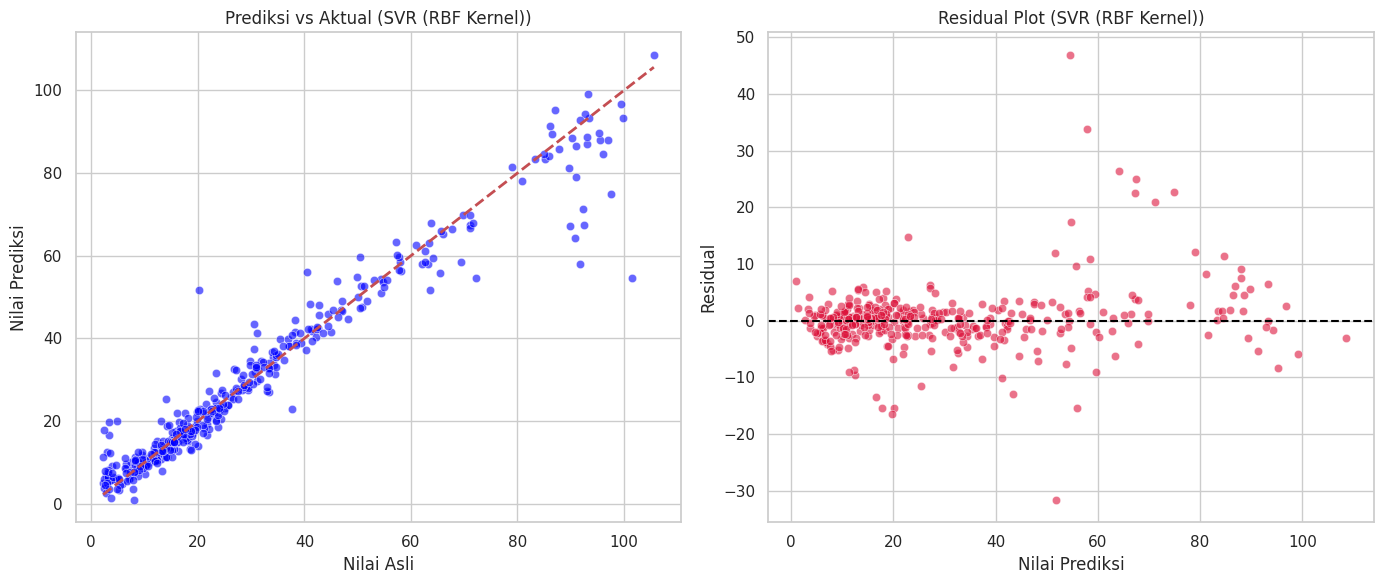

In [17]:
best_model_name = df_final.iloc[0]['Model']
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

print(f"Model Terbaik: {best_model_name}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f"Prediksi vs Aktual ({best_model_name})")
plt.xlabel("Nilai Asli")
plt.ylabel("Nilai Prediksi")

residuals = y_test - y_pred_best
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6, color='crimson')
plt.axhline(0, color='black', linestyle='--')
plt.title(f"Residual Plot ({best_model_name})")
plt.xlabel("Nilai Prediksi")
plt.ylabel("Residual")

plt.tight_layout()
plt.show()